Need to use more robust regression models to imporve metric!

SkLearn has several robust regression classes I could use!

# Import Data and Modules/Packages

# Import Data/Modules/Packages/Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")


from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.regression import linear_model


In [5]:
# from google.colab import files
# math = files.upload()

In [6]:
df = pd.read_csv('student-mat.csv', sep=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


***Target Variable for Regression: Final Grade (G3)***

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_labeled = df.copy()
for c in df.columns:
    if df_labeled[c].dtypes =='O':
        df_labeled[c] = le.fit_transform(df_labeled[c])
df_labeled.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,0,4,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,1,0,1,1,1,0,2,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,1,1,1,1,1,0,2,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,1,0,1,4,2,1,3,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,1,0,1,3,3,2,2,...,4,3,2,1,2,5,4,6,10,10


# Eda

### Mother and Father Occupations

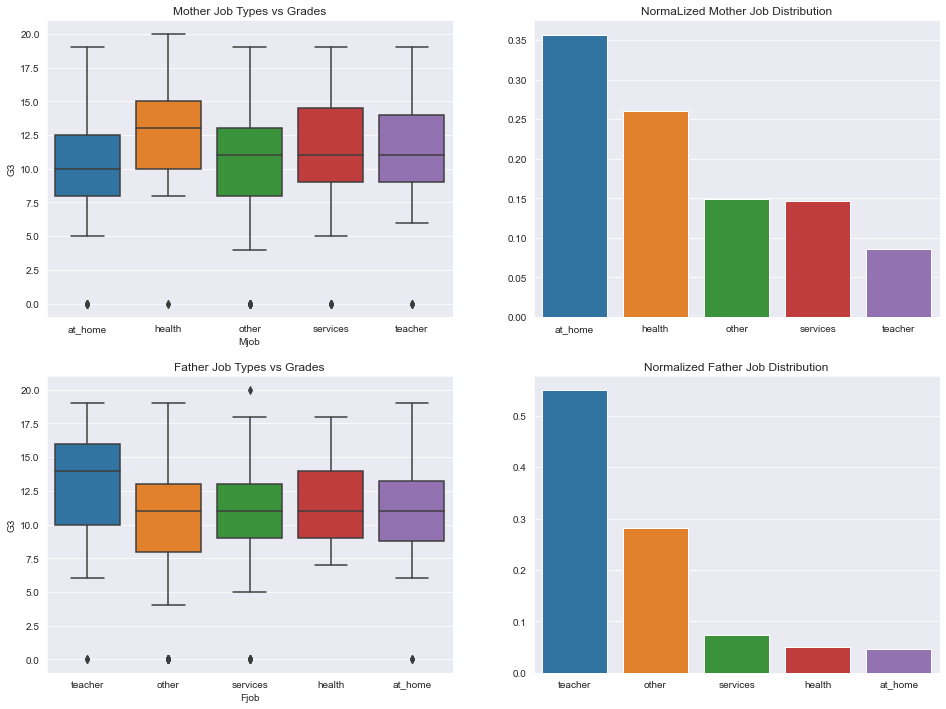



               sum_sq     df         F    PR(>F)
C(Fjob)     66.718976    4.0  0.815341  0.515924
C(Mjob)    264.307235    4.0  3.229975  0.012612
Residual  7896.546217  386.0       NaN       NaN


In [8]:
fig, ax = plt.subplots(2, 2, figsize=(16,12))


sns.boxplot(data=df, x='Mjob', y=df.G3, ax=ax[0][0])
ax[0][0].set_title('Mother Job Types vs Grades')
sns.barplot(data=df, x=df['Mjob'].unique(), y=df.Mjob.value_counts(normalize=True).values, ax=ax[0][1])
ax[0][1].set_title('NormaLized Mother Job Distribution')

sns.boxplot(data=df, x='Fjob', y=df.G3, ax=ax[1][0])
ax[1][0].set_title('Father Job Types vs Grades')
sns.barplot(data=df, x=df['Fjob'].unique(), y=df.Fjob.value_counts(normalize=True).values, ax=ax[1][1])
ax[1][1].set_title('Normalized Father Job Distribution')
plt.show()

print('')
print('')

formula = 'G3 ~ C(Fjob)+C(Mjob)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

    EDA
    1. No particular group stands out except for potentially those whose mothers work in health 
    and fathers work as teachers
    2. A large portion of mothers stayed at home as their occupation (roughly 35%)
    3. An even larger portion of dads were teachers (over 50%)
        This coincides with the high grades of students whos fathers are teachers

 
    ANOVA Analysis results
    1. The mother's occupation does have an effect on the final grade of the student
    2. The father's occupation does **NOT** have an effect on the final grade of the student
    3. Together the correlation drops. Perhaps not using the Father's job type in the model will improve accuracy

### Guardianship

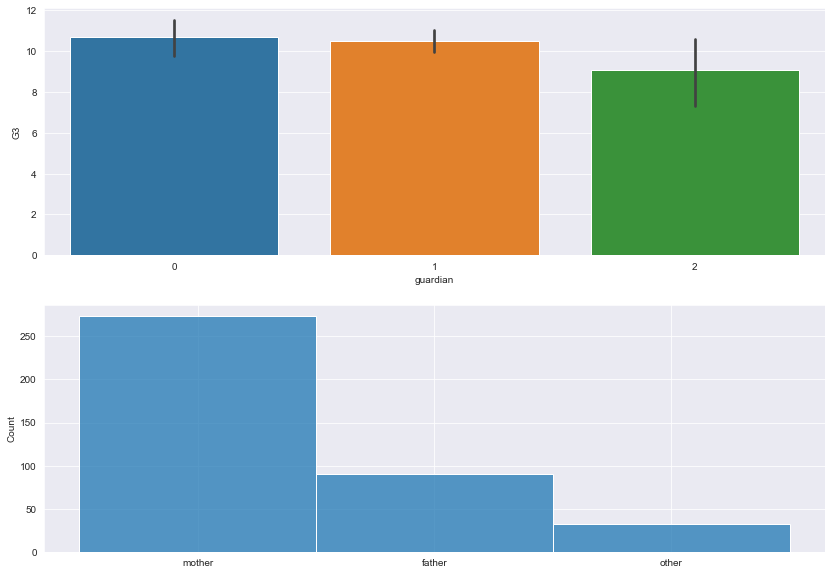

In [9]:
from scipy.stats import ttest_ind
df['guardian'] = le.fit_transform(df['guardian'])

fig, ax = plt.subplots(2,1, figsize=(14, 10))
sns.barplot(df['guardian'], df['G3'], ax=ax[0])
sns.histplot(le.inverse_transform(df['guardian']), ax=ax[1])
plt.show()

    T-test Results
    The Welch's T-test shows that there is no 
    statistically significant difference between the grades based on guardianship type

## Time Allocation

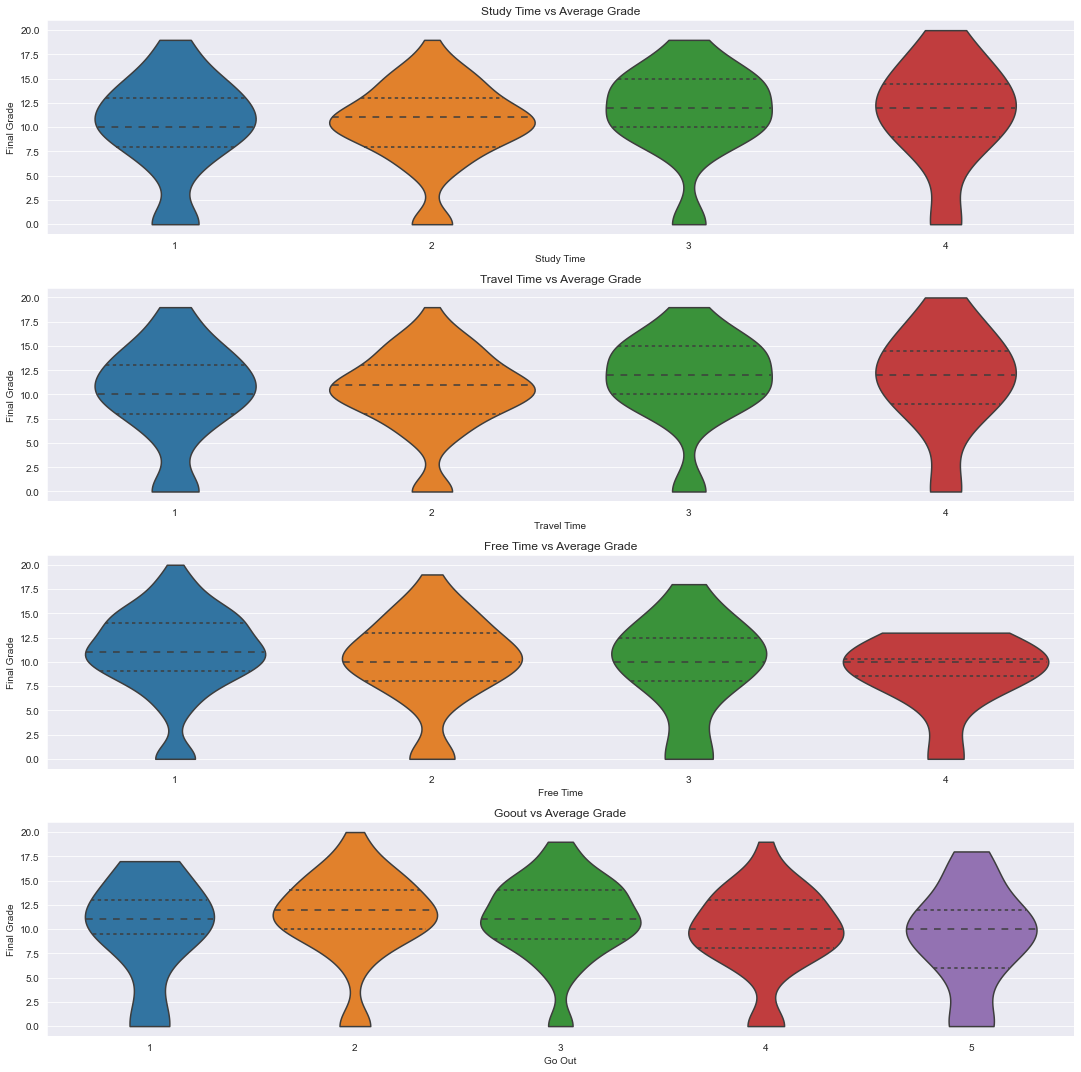





ANOVA Test for All Time Based Data
Go out ANOVA Test:
                    sum_sq     df         F    PR(>F)
C(freetime)     279.005927    4.0  3.492736  0.008115
C(goout)        268.653361    4.0  3.363138  0.010097
C(studytime)     64.286305    3.0  1.073024  0.360406
C(traveltime)    75.079173    3.0  1.253172  0.290236
Residual       7588.767058  380.0       NaN       NaN


In [10]:
fig, ax = plt.subplots(4, figsize=(15,15))
sns.violinplot(x=df['studytime'], y=df['G3'], ax=ax[0], cut=0, inner='quartile')

ax[0].set_title('Study Time vs Average Grade')
ax[0].set_xlabel('Study Time')
ax[0].set_ylabel('Final Grade')

sns.violinplot(x=df['studytime'], y=df['G3'], ax=ax[1], cut=0, inner='quartile')

ax[1].set_title('Travel Time vs Average Grade')
ax[1].set_xlabel('Travel Time')
ax[1].set_ylabel('Final Grade')

sns.violinplot(x=df['traveltime'], y=df['G3'], ax=ax[2], cut=0, inner='quartile')

ax[2].set_title('Free Time vs Average Grade')
ax[2].set_xlabel('Free Time')
ax[2].set_ylabel('Final Grade')

sns.violinplot(x=df['goout'], y=df['G3'], ax=ax[3], cut=0, inner='quartile')
ax[3].set_title('Goout vs Average Grade')
ax[3].set_xlabel('Go Out')
ax[3].set_ylabel('Final Grade')

plt.tight_layout()
plt.show()


print('')
print('')
print('')
print('')


print('ANOVA Test for All Time Based Data')
formula = 'G3 ~ C(freetime)+C(goout)+C(studytime)+C(traveltime)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print('Go out ANOVA Test:')
print(table)



    We will be using the goout data for our model
    
    ANOVA test for all kinds of time related daya results in the conclusion that their interactions do not have a significant affect on the final grade

## Alcohol Consumption

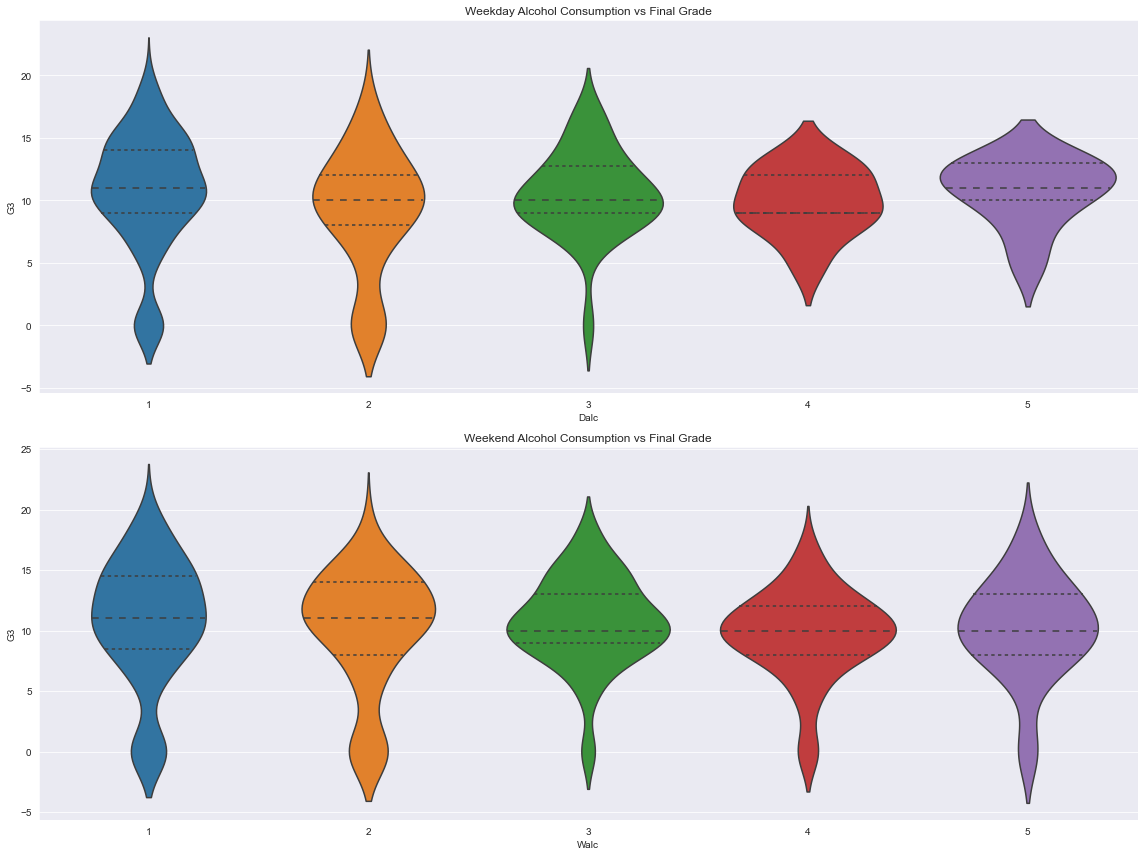

In [11]:
fig, ax = plt.subplots(2, figsize=(16,12))
sns.violinplot(x=df['Dalc'], y=df['G3'], ax=ax[0], inner='quartile')
sns.violinplot(x=df['Walc'], y=df['G3'], ax=ax[1], inner='quartile')
ax[0].set_title('Weekday Alcohol Consumption vs Final Grade')
ax[1].set_title('Weekend Alcohol Consumption vs Final Grade')
plt.tight_layout()
plt.show()

There are still a bunch of remaining columns to do EDA on

ANOVA Test for Failures
                  sum_sq     df          F        PR(>F)
C(failures)  1137.135742    3.0  20.778271  1.642166e-12
Residual     7132.773118  391.0        NaN           NaN


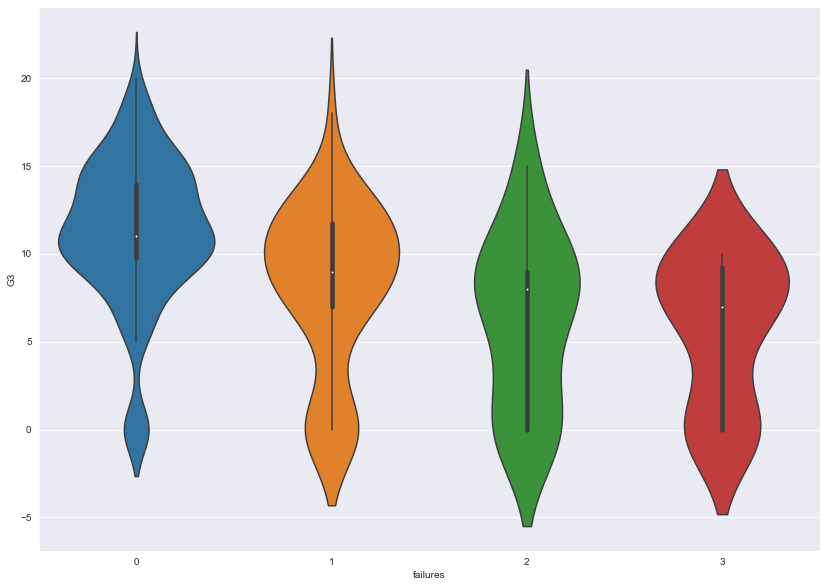

In [12]:
fig, ax = plt.subplots(figsize=(14,10))
sns.violinplot(x=df['failures'], y=df['G3'], ax=ax)

print('ANOVA Test for Failures')
formula = 'G3 ~ C(failures)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

Different categorical levels of failures have a significant affect on the final grade of the student. Let's see if the potential variance explanations between failures, free time, studytime, traveltime, and go out level 

In [13]:
print('ANOVA Test for Failures')
formula = 'G3 ~ C(freetime)+C(goout)+C(studytime)+C(traveltime) + C(failures)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

ANOVA Test for Failures
                    sum_sq     df          F        PR(>F)
C(freetime)     338.549106    4.0   4.852962  7.936112e-04
C(goout)        162.961195    4.0   2.335982  5.504563e-02
C(studytime)     34.860026    3.0   0.666272  5.732007e-01
C(traveltime)    42.651315    3.0   0.815185  4.860691e-01
C(failures)    1013.761805    3.0  19.375812  1.052559e-11
Residual       6575.005253  377.0        NaN           NaN


# Modeling

## Using G1 and G2 Data

In [150]:
from scipy import stats
z = np.abs(stats.zscore(df_labeled))
df_labeled_o = df_labeled[(z < 3).all(axis=1)]

final_df = df_labeled_o


X_train, X_test, y_train, y_test = train_test_split(final_df.drop(columns=['G3']), final_df.G3, random_state=3)

# A constant is needed for the OLS model or else there will be biased
mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
print(res.summary())

from sklearn.feature_selection import RFE
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_train, y_train)
y_pred = selector.predict(X_test)

remaining_features = zip(list(selector.support_), list(final_df.columns))

final_features = pd.DataFrame(remaining_features)
features_5 = final_features[final_features[0] == True]
display(features_5)

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     49.19
Date:                Wed, 28 Jul 2021   Prob (F-statistic):           1.36e-83
Time:                        20:56:25   Log-Likelihood:                -476.65
No. Observations:                 256   AIC:                             1019.
Df Residuals:                     223   BIC:                             1136.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
school         0.6420      0.395      1.626      0.1

,0,1
1,True,sex
14,True,failures
15,True,schoolsup
31,True,G2
32,True,G3


By iteratively removing features based on regression p-values, we have achieved a superior model. This can be done atuomatically rather than manually. 

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     226.9
Date:                Wed, 28 Jul 2021   Prob (F-statistic):           9.41e-91
Time:                        20:57:13   Log-Likelihood:                -443.55
No. Observations:                 256   AIC:                             899.1
Df Residuals:                     250   BIC:                             920.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3023      0.335      6.869      0.0

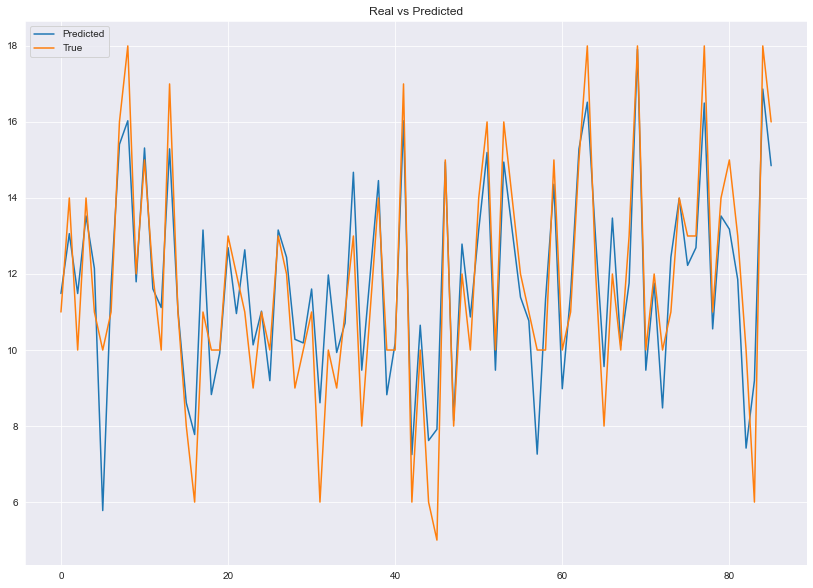

In [152]:
final_df = df_labeled_o[['sex','failures', 'schoolsup', 'G1', 'G2']]

X_train, X_test, y_train, y_test = train_test_split(final_df, df_labeled_o['G3'].replace(0, int(df_labeled_o.G3.mean())), random_state=3)

# A constant is needed for the OLS model or else there will be biased
mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
print(res.summary())

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)


fig, ax = plt.subplots(figsize=(14,10))
ax.plot(y_pred, label='Predicted')
ax.plot(y_test.values, label='True')
plt.legend()
ax.set_title('Real vs Predicted')
fig.show()

## Without G1 and G2 Data

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     14.57
Date:                Wed, 28 Jul 2021   Prob (F-statistic):           8.50e-38
Time:                        20:53:05   Log-Likelihood:                -605.59
No. Observations:                 256   AIC:                             1273.
Df Residuals:                     225   BIC:                             1383.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
school         1.4974      0.645      2.321      0.0

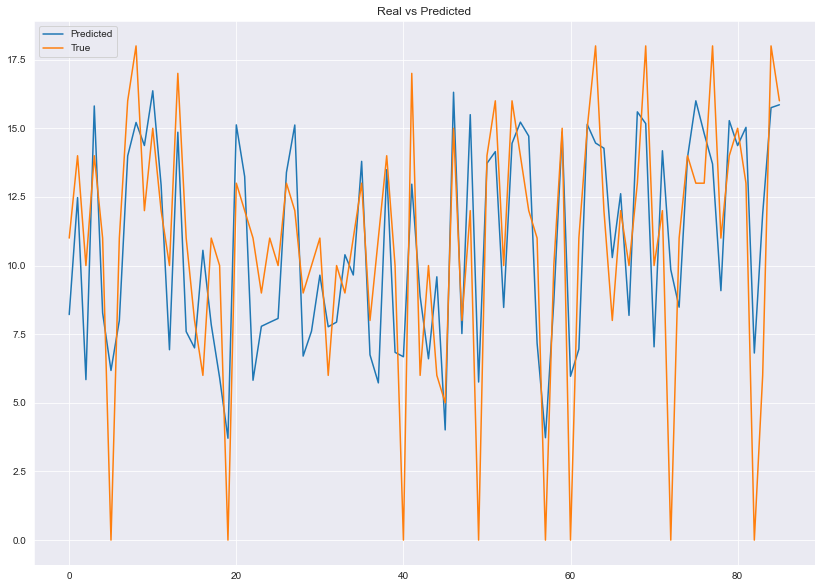

In [145]:
from scipy import stats
z = np.abs(stats.zscore(df_labeled))
df_labeled_o = df_labeled[(z < 3).all(axis=1)]

final_df = df_labeled_o


X_train, X_test, y_train, y_test = train_test_split(final_df.drop(columns=['G1', 'G2', 'G3']), final_df.G3, random_state=3)

# A constant is needed for the OLS model or else there will be biased
mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
print(res.summary())


from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(mean_squared_error(y_pred, y_test.values))


fig, ax = plt.subplots(figsize=(14,10))
ax.plot(y_pred, label='Predicted')
ax.plot(y_test.values, label='True')
plt.legend()
ax.set_title('Real vs Predicted')
fig.show()

## Robust

Need to use a robust model to potentially increase R^2 value